In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import glob

from sklearn.model_selection import train_test_split, cross_val_score


In [0]:
IMAGE_FOLDER_PATH="/content/gdrive/My Drive/dental/rvg"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150


In [0]:
s=pd.read_csv("/content/gdrive/My Drive/dental/lab.csv")

In [0]:
target=s['normal']

In [0]:
targets=list()
full_paths=list()
i=0
for file_name in FILE_NAMES:
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(str(target[i]))
    i=i+1

dataset=pd.DataFrame()
dataset['image_path']=full_paths
dataset['target']=targets

In [0]:
dataset

,image_path,target
0,/content/gdrive/My Drive/dental/rvg/138.jpg,1
1,/content/gdrive/My Drive/dental/rvg/139.jpg,1
2,/content/gdrive/My Drive/dental/rvg/142.jpg,1
3,/content/gdrive/My Drive/dental/rvg/143.jpg,1
4,/content/gdrive/My Drive/dental/rvg/144.jpg,1
...,...,...
657,/content/gdrive/My Drive/dental/rvg/122.jpg,0
658,/content/gdrive/My Drive/dental/rvg/123.jpg,0
659,/content/gdrive/My Drive/dental/rvg/124.jpg,1
660,/content/gdrive/My Drive/dental/rvg/125.jpg,0


In [0]:
dataset_train, dataset_test=train_test_split(dataset,test_size=0.2,
                                                 random_state=42)

In [0]:
def preprocessing_data(dataset):
    X = []
    y = []
    for i in dataset.index:
      img = cv2.imread(dataset['image_path'][i],cv2.IMREAD_GRAYSCALE)
      img = skimage.transform.resize(img, (150, 150, 3))
      img = np.asarray(img)
      X.append(img)
      y.append(dataset['target'][i])
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [0]:
X_train, y_train =  preprocessing_data(dataset_train)


In [0]:
X_test , y_test  =  preprocessing_data(dataset_test)

In [0]:
print(X_train.shape,'\n',X_test.shape)


In [0]:
print(y_train.shape,'\n',y_test.shape)


In [0]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [0]:
print(y_train.shape,'\n',y_test.shape)


(529, 2) 
 (133, 2)


In [0]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:

from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
from keras import backend as K
K.common.set_image_dim_ordering('th')

In [0]:
X_train=X_train.reshape(529,3,150,150)
X_test=X_test.reshape(133,3,150,150)

In [0]:
print(X_train.shape,'\n',X_test.shape)


(529, 150, 150, 3) 
 (133, 150, 150, 3)


In [0]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False , input_shape=(150,150,3))

In [0]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [0]:
model = Model(inputs=base_model.input, outputs=predictions)


In [0]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [0]:
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
batch_size = 64
epochs = 100

In [0]:

history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 529 samples, validate on 133 samples
Epoch 1/100
529/529 [==============================] - 29s 55ms/step - loss: 0.7120 - accuracy: 0.5709 - val_loss: 0.6934 - val_accuracy: 0.5188
Epoch 2/100
 32/529 [>.............................] - ETA: 2s - loss: 0.6206 - accuracy: 0.5625

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


529/529 [==============================] - 3s 5ms/step - loss: 0.6457 - accuracy: 0.6314 - val_loss: 0.7448 - val_accuracy: 0.5188
Epoch 3/100
529/529 [==============================] - 3s 5ms/step - loss: 0.6172 - accuracy: 0.6276 - val_loss: 0.8154 - val_accuracy: 0.5188
Epoch 4/100
529/529 [==============================] - 3s 5ms/step - loss: 0.5941 - accuracy: 0.6597 - val_loss: 1.0536 - val_accuracy: 0.5188
Epoch 5/100
529/529 [==============================] - 3s 5ms/step - loss: 0.5219 - accuracy: 0.7221 - val_loss: 1.5273 - val_accuracy: 0.5188
Epoch 6/100
529/529 [==============================] - 3s 5ms/step - loss: 0.5561 - accuracy: 0.6730 - val_loss: 1.3952 - val_accuracy: 0.5188
Epoch 7/100
529/529 [==============================] - 3s 5ms/step - loss: 0.5134 - accuracy: 0.6919 - val_loss: 1.6957 - val_accuracy: 0.5188
Epoch 8/100
529/529 [==============================] - 3s 5ms/step - loss: 0.4976 - accuracy: 0.7259 - val_loss: 2.2891 - val_accuracy: 0.5188
Epoch 9/100

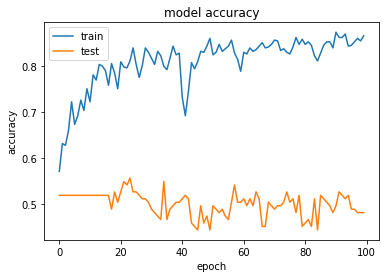

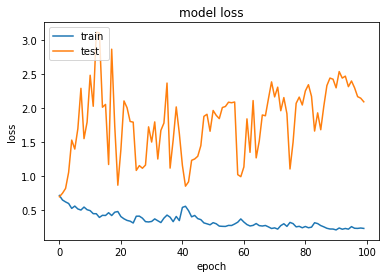

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:

from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [0]:
from sklearn import metrics
accuracy = metrics.accuracy_score(pred, y_true) * 100
print("Accuracy with SVM: {0:.2f}%".format(accuracy))
precision = metrics.precision_score(pred, y_true) * 100
print("precision with SVM: {0:.2f}%".format(precision))
recall = metrics.recall_score(pred, y_true) * 100
print("recall with SVM: {0:.2f}%".format(recall))
f1 = metrics.f1_score(pred, y_true) * 100
print("F1 score with SVM: {0:.2f}%".format(f1))


Accuracy with SVM: 48.12%
precision with SVM: 78.26%
recall with SVM: 50.00%
F1 score with SVM: 61.02%


In [0]:

# calculate the FPR and TPR for all thresholds of the classification
probs = model.predict_proba(X_test)
probs = probs[:, 1]
tree_fpr, tree_tpr, thresholds = metrics.roc_curve(y_test, probs)
tree_auc = metrics.roc_auc_score(y_test, probs)

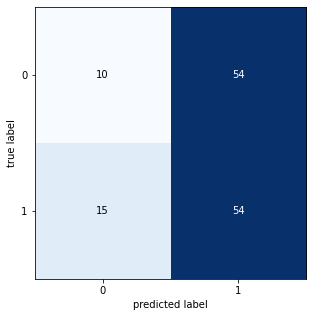

In [0]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()